In [1]:
import os
import cv2
import random
import torch
import numpy as np
from PIL import Image
from utils.DiffusionUtils import DiffusionUtils
from utils.TemplateManager import TemplateManager

from ptp.AttentionControls import AttentionStore
from ptp.ptp_utils import text2image_ldm_stable, view_images
from ptp.attn_utils import aggregate_attention, show_cross_attention, show_self_attention_comp

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

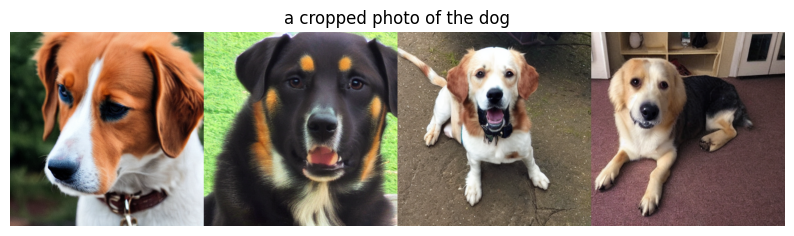

In [2]:
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("dog"), 4)

In [2]:
concept = "canada_bear"
origin_img_path = f"/home/jack/Code/Research/instree_main/input_concepts/{concept}/v0/"
origin_img_path += random.choice(os.listdir(origin_img_path))
concept_path = f"/home/jack/Code/Research/instree_analysis/experiments/20250312_instree_original/outputs/{concept}/v0/learned_embeds.bin"
concepts = torch.load(concept_path)
DiffusionUtils.add_new_vocab('<*>', concepts['<*>'])
DiffusionUtils.add_new_vocab('<&>', concepts['<&>'])

New token added:  <*>
Current vocab size:  49409
All new tokens:  {'<*>': 49408}
New token added:  <&>
Current vocab size:  49410
All new tokens:  {'<*>': 49408, '<&>': 49409}


In [4]:
origin_img_path = "/home/jack/Code/Research/instree_main/input_concepts/canada_bear/v0/IMG_4223 Large.png"
paper_concept_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"
paper_concepts = torch.load(paper_concept_path)
print(paper_concepts.keys())
DiffusionUtils.reset_vocab()
DiffusionUtils.add_new_vocab('<cat_v1>', paper_concepts['cat']['<cat_v1>'])
DiffusionUtils.add_new_vocab('<cat_v2>', paper_concepts['cat']['<cat_v2>'])
DiffusionUtils.add_new_vocab('<bear_v1>', paper_concepts['bear']['<bear_v1>'])
DiffusionUtils.add_new_vocab('<bear_v2>', paper_concepts['bear']['<bear_v2>'])

dict_keys(['cat', 'bear', 'buddha', 'mug', 'teapot', 'round_bird', 'elephant', 'wooden_pot', 'physics_mug', 'red_teapot', 'mug_buildings'])
Vocabulary has been reset.
Current vocab size:  49408
New token added:  <cat_v1>
Current vocab size:  49409
All new tokens:  {'<cat_v1>': 49408}
New token added:  <cat_v2>
Current vocab size:  49410
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409}
New token added:  <bear_v1>
Current vocab size:  49411
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410}
New token added:  <bear_v2>
Current vocab size:  49412
All new tokens:  {'<cat_v1>': 49408, '<cat_v2>': 49409, '<bear_v1>': 49410, '<bear_v2>': 49411}


  0%|          | 0/25 [00:00<?, ?it/s]

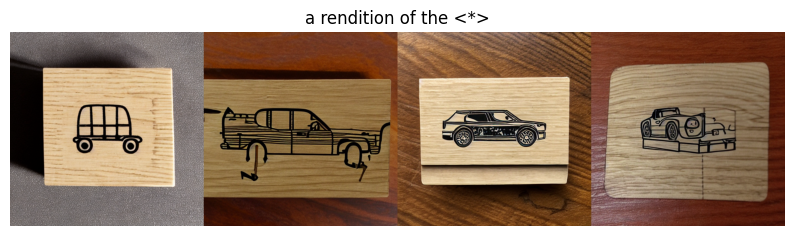

  0%|          | 0/25 [00:00<?, ?it/s]

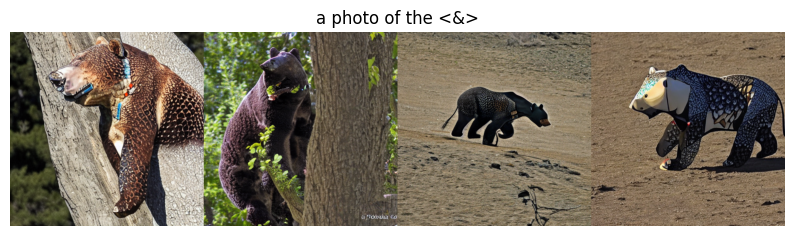

  0%|          | 0/25 [00:00<?, ?it/s]

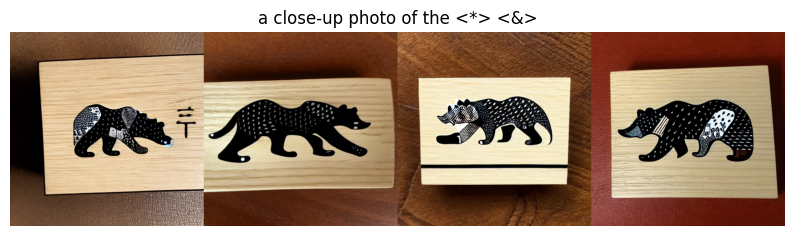

In [5]:
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("<*>"), 4)
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("<&>"), 4)
prompt_tmp = TemplateManager.get_random_template("IMG")
DiffusionUtils.run_prompt(prompt_tmp.format("<*> <&>"), 4)

  0%|          | 0/26 [00:00<?, ?it/s]

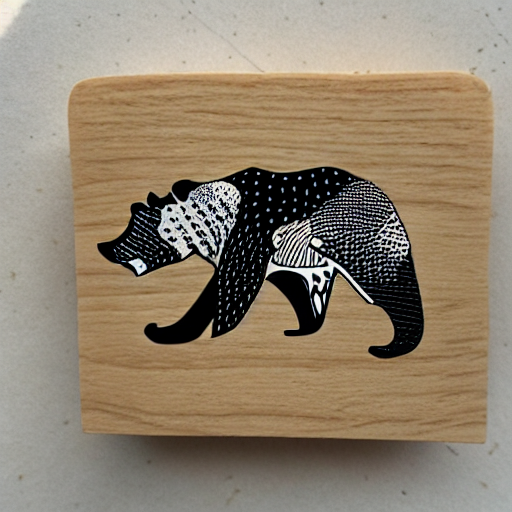

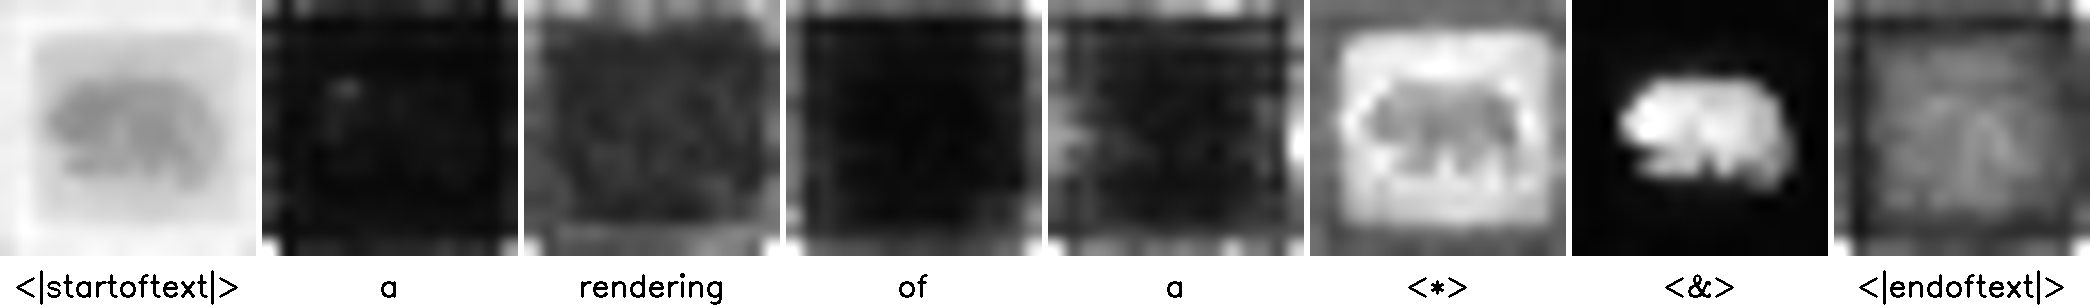

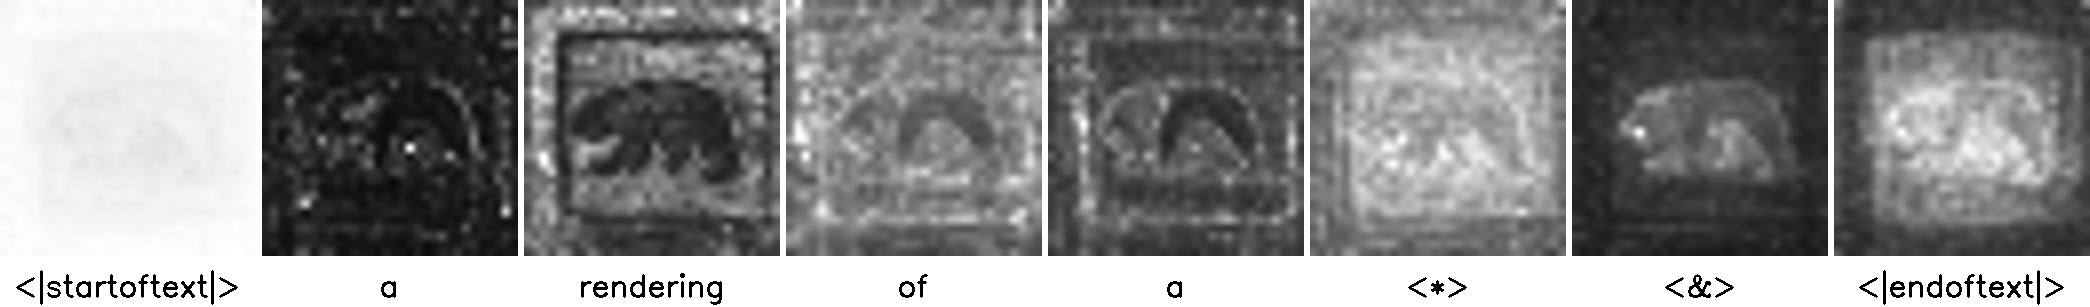

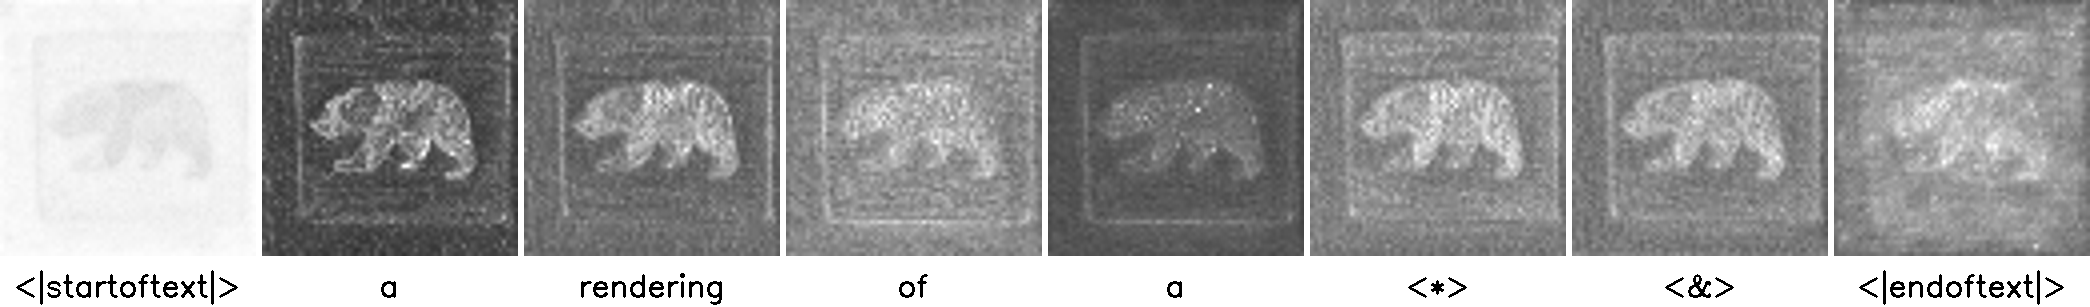

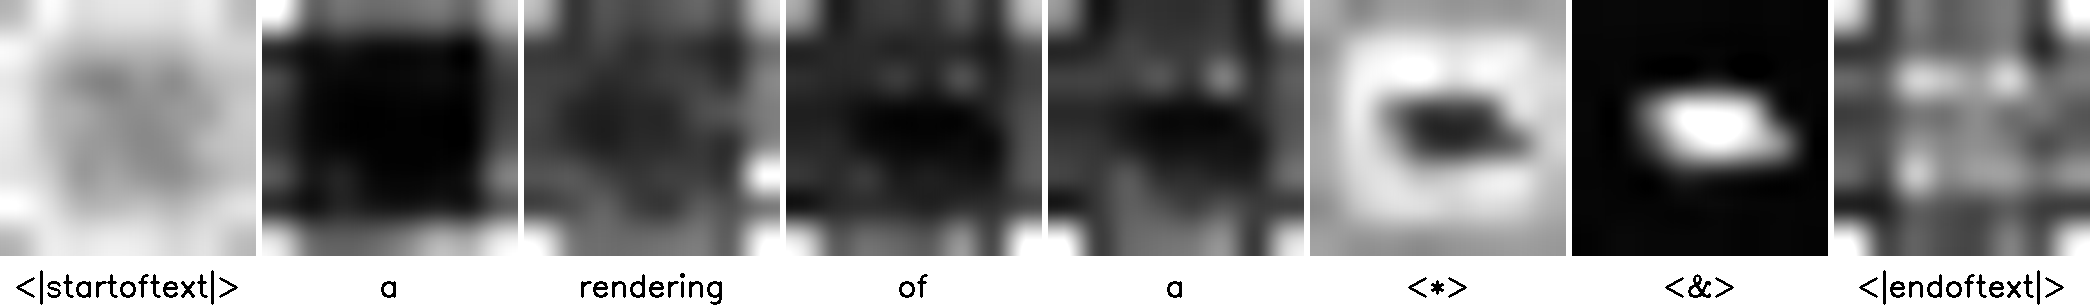

In [3]:
SEED = 42
torch.manual_seed(SEED)
controller = AttentionStore()
prompts = [TemplateManager.get_random_template("IMG").format("<*> <&>")]

images, x_t = text2image_ldm_stable(
    DiffusionUtils.pipe, 
    prompts,
    controller, 
    latent=None, 
    num_inference_steps=25, guidance_scale=7.5, 
    generator=None, low_resource=False)
view_images(images)

attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=16, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=32, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=64, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=8, from_where=("mid",))

In [9]:
def otsu_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to a color image by converting it to grayscale.
    Parameters: image (np.ndarray): Input color image of shape (H, W, C). 
    Returns: np.ndarray: Binary thresholded image.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return np.expand_dims(binary_image, axis=2)

def get_image_latent(img_path):
    image = Image.open(img_path).resize((512, 512))
    image = np.expand_dims(image, axis=0)
    image_latent = torch.tensor(DiffusionUtils.image2latent(image[:,:,:,:3]), dtype=torch.float16).to(DiffusionUtils.device)
    return image_latent

  0%|          | 0/1 [00:00<?, ?it/s]

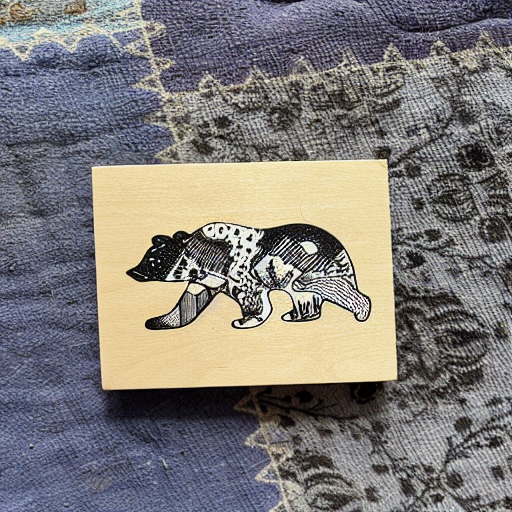

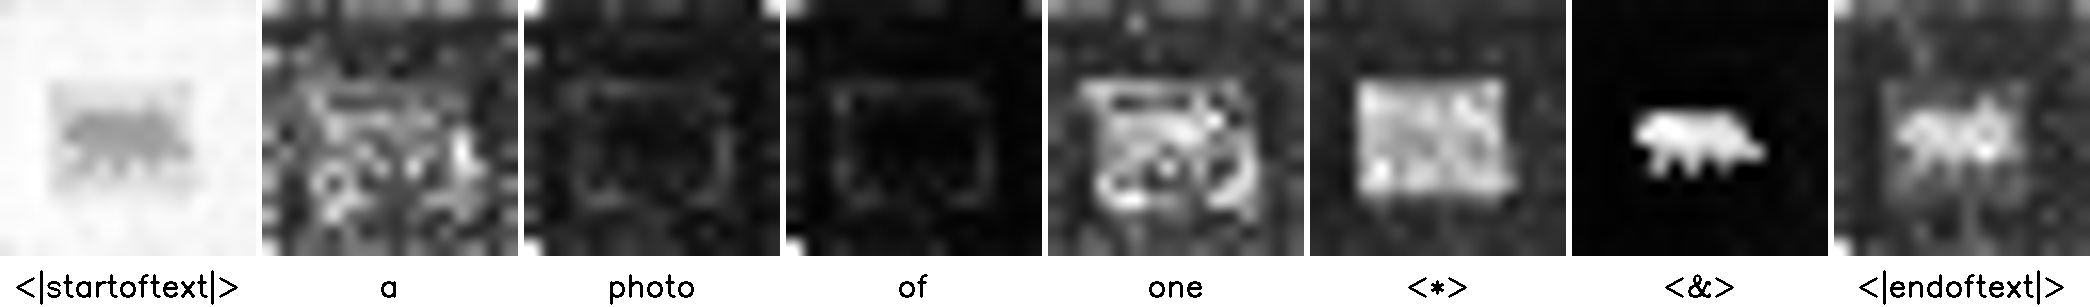

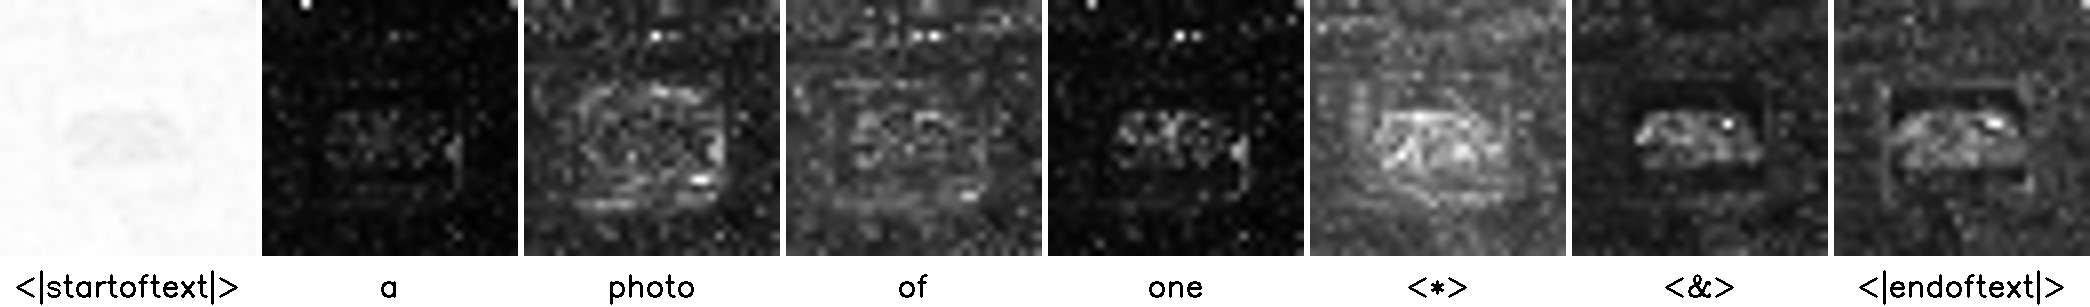

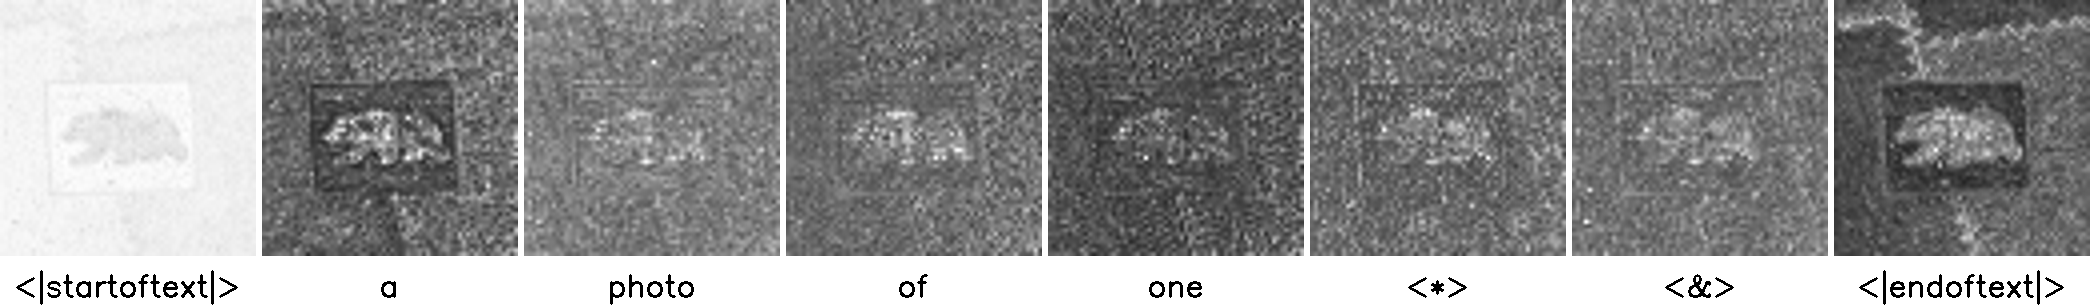

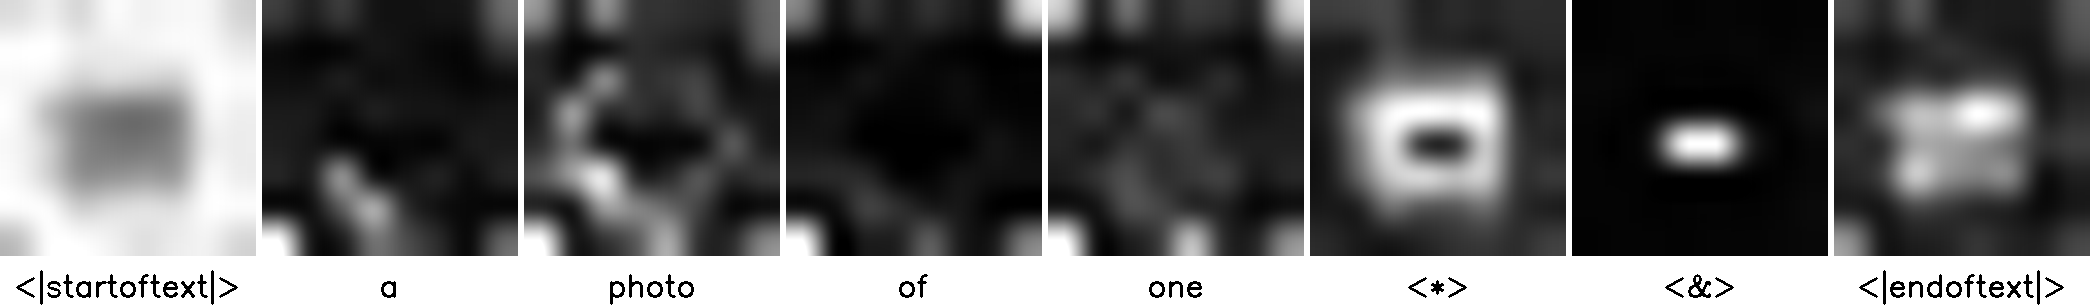

In [10]:
tokenzier = DiffusionUtils.pipe.tokenizer
SEED = 42
torch.manual_seed(SEED)
controller = AttentionStore()
prompts = [TemplateManager.get_random_template("IMG").format("<*> <&>")]

latent = get_image_latent(origin_img_path)

images, x_t = text2image_ldm_stable(
    DiffusionUtils.pipe, 
    prompts,
    controller, 
    latent=latent, 
    num_inference_steps=1, guidance_scale=7.5, 
    generator=None, low_resource=False)
view_images(images)

attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=16, from_where=("up", "down"))
# attn_map_self = show_self_attention_comp(prompts, controller, res=16, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=32, from_where=("up", "down"))
# attn_map_self = show_self_attention_comp(prompts, controller, res=32, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=64, from_where=("up", "down"))
# attn_map_self = show_self_attention_comp(prompts, controller, res=64, from_where=("up", "down"))
attn_map, text = show_cross_attention(DiffusionUtils.pipe.tokenizer, prompts, controller, res=8, from_where=("mid",))
# attn_map_self = show_self_attention_comp(prompts, controller, res=8, from_where=("mid",))

In [4]:
attn_map.shape

(8, 256, 256, 3)

In [10]:
# # TODO write this to a function
# attn_list = []
# attn_map = aggregate_attention(prompts, controller, 16, ("up", "down"), True, 0)
# for i in range(len(DiffusionUtils.pipe.tokenizer.encode(prompts[0]))):
#     image = attn_map[:, :, i]
#     image = 255 * image / image.max()
#     image = image.unsqueeze(-1).expand(*image.shape, 3)
#     image = image.numpy().astype(np.uint8)
#     image = np.array(Image.fromarray(image).resize((256, 256)))
#     attn_list.append(image)
# attn_map = np.stack(attn_list, axis=0)

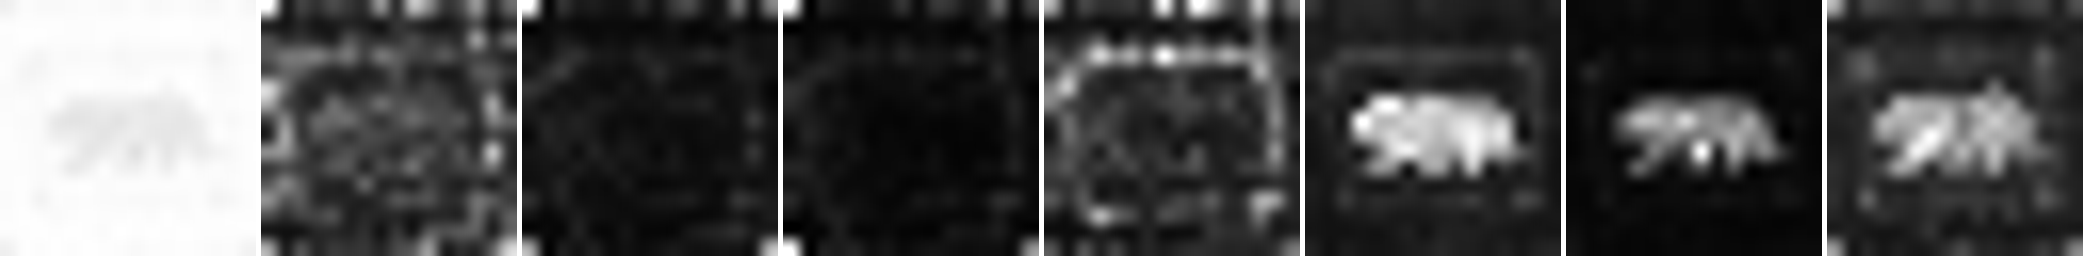

In [11]:
view_images(attn_map)

In [12]:
text

['<|startoftext|>',
 'a',
 'photo',
 'of',
 'the',
 'nice',
 '<bear_v2>',
 '<|endoftext|>']

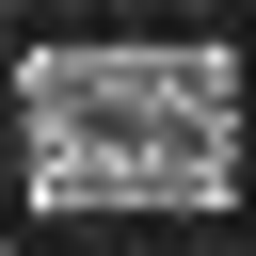

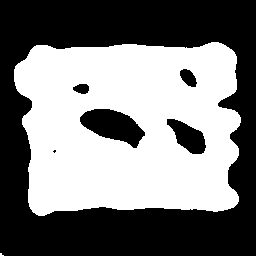

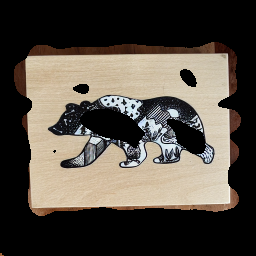

In [16]:
view_images(attn_map[-2])
mask = otsu_thresholding((attn_map[-2]))
mask = mask / 255
view_images(mask * 255)
masked_image = mask * cv2.resize(images[0], (256, 256))
view_images(masked_image)